# Q1
What does a generative adversarial network (GAN) minimizes? What does it correspond to? $KL(P_{data}||P_{fake})$ or $KL(P_{fake}||P_{data})$? Or something else?

*Your answer*

# Q2
What is mode collapse? If we know that GAN training minimizes the above question's answer, why does this problem still exist?

*Your answer*

# Q3
Why does the discriminator saturate in the original GAN formulation? What becomes an issue when the discriminator saturate? (i.e. why is the saturation a problem?)

*Your answer*

# Q3
For the range $x \in [-10, 10]$, plot $\sigma(x)$ vs $\nabla_{x}\log(1-\sigma(x))$ and $\sigma(x)$ vs $\nabla_x \log \sigma(x)$.

In [ ]:
# your plotting code

# Q4 - GAN Implementation

We are going to implement a GAN with PyTorch on a mock data. Most of the code is implemented for you. You are going to fill areas with `# >`.

In [ ]:
from IPython.display import HTML
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [ ]:
def sample_from_img(n, img_url):
    # img_url must contain a black and white png image
    img = plt.imread(img_url)
    assert len(img.shape) == 2
    shape = np.array(img.shape)

    samples = []
    while len(samples) != n:
        x = np.random.rand(2)
        x_hat = (x * shape).astype(int)
        x_hat[0] = np.clip(x_hat[0], 0, shape[0]-1)
        x_hat[1] = np.clip(x_hat[1], 0, shape[1]-1)
        if np.random.rand() < img[shape[0]-x_hat[0]-1, x_hat[1]]:
            # add a normalized sample
            x_n = x*2-1
            samples.append([x_n[1], x_n[0]])
    samples = np.array(samples)
    return samples

def sample_swissroll(N):
    r = torch.sqrt(torch.linspace(0, 1, N)) * 780 * (2*np.pi)/360
    dx = -torch.cos(r)*r*0.05 + torch.rand(N) * (0.05)
    dy = torch.sin(r)*r*0.05 + torch.rand(N) * (0.05)
    x = torch.stack([dx, dy]).t()
    return x

def sample_25_modes(N):
    x_axis = np.linspace(-10, 10, 5)
    y_axis = np.linspace(-10, 10, 5)
    it = 0
    x = torch.empty(N, 2, dtype=torch.float)
    CLUSTER_SIZE = N // 25
    for i in range(5):
        for j in range(5):
            x[it*CLUSTER_SIZE:(it+1)*CLUSTER_SIZE,0] = torch.randn(CLUSTER_SIZE) * 0.05 + x_axis[i]
            x[it*CLUSTER_SIZE:(it+1)*CLUSTER_SIZE,1] = torch.randn(CLUSTER_SIZE) * 0.05 + y_axis[j]
            it += 1
    return x

def save_animation(timesteps, d_field, lims, alpha=1.0, s=20):
    size = timesteps[0].shape[0]//2
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    canvas = ax.scatter([], [], alpha=alpha, s=s)

    colormap = plt.get_cmap("rainbow",101)
    colorlist = [colormap(i) for i in range(101)]
    xv, yv = torch.meshgrid(torch.linspace(lims[0], lims[1], 40), torch.linspace(lims[0], lims[1], 40))
    field = torch.stack([xv.contiguous().view(-1), yv.contiguous().view(-1)], dim=1).numpy()

    colors = []
    for i in range(1600+size*2):
        if i < 1600:
            colors.append(colorlist[50])
        elif i < (1600+size):
            colors.append('k')
        else:
            colors.append('tab:orange')

    def init():
        data = np.zeros((1600+2*size, 2))
        data[:1600] = field
        data[1600:] = timesteps[0]
        canvas.set_offsets(data)
        canvas.set_color(colors)
        return (canvas,)

    def animate(t):
        data = canvas.get_offsets()
        indexes = d_field[t]
        for j in range(1600):
            colors[j] = colorlist[indexes[j]]
        data[1600:] = timesteps[t]
        canvas.set_offsets(data)
        canvas.set_color(colors)
        return (canvas,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(timesteps), interval=20, blit=True)
    return anim

Let's sample some data. There are three different datasets in this tutorial. All of them are 2-dimensional, so you can see them in a scatter plot.

In [ ]:
# number of data points
N = 2500
img_url = "https://media-exp1.licdn.com/dms/image/C560BAQGUg-3pKJ16og/company-logo_200_200/0/1521972118427?e=2159024400&v=beta&t=LRX6mzS8FI-WC436To-z_PYyZKsMqYkwKyrGZxL0Ak8"
x = torch.tensor(sample_from_img(N, img_url), dtype=torch.float)
# x = sample_25_modes(N)
# x = sample_swissroll(N)

(-0.881571239233017,
 0.9218168914318084,
 -0.9408694267272949,
 0.860796308517456)

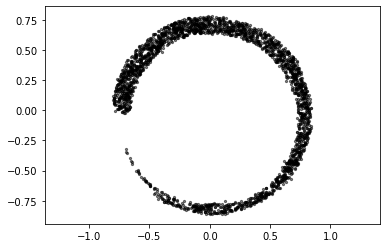

In [ ]:
# > visualize the data in a scatter plot.
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, c="k", s=5)
plt.axis("equal")

In [ ]:
# let's set the noise dimension to 2
Z_DIM = 2

# create a generator as a torch.nn.Module object. (e.g. torch.nn.Sequential(torch.nn.Linear(Z_DIM, 32), ...))
# name this variable G
# >
G = torch.nn.Sequential(
    torch.nn.Linear(Z_DIM, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)
# create a generator as a torch.nn.Module object. (e.g. torch.nn.Sequential(torch.nn.Linear(Z_DIM, 32), ...))
# name this variable D
# >
D = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1)
)

In [ ]:
# most of the time you should set the optimizer to Adam optimizer.
# see: https://github.com/soumith/ganhacks by Soumith Chintala et al.
optim_g = torch.optim.Adam(lr=0.0001, params=G.parameters())
optim_d = torch.optim.Adam(lr=0.0001, params=D.parameters())

In [ ]:
# some hyperparameters
EPOCH = 200
BATCH_SIZE = 50
LOOP_PER_EPOCH = N // BATCH_SIZE

### Initial state

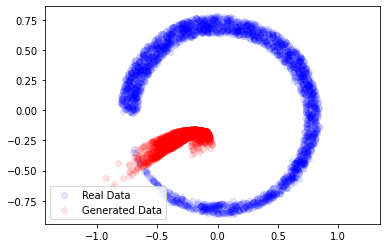

In [ ]:
# Firstly, let's see what the generator produces
# before doing any training. Visualize the real
# data and the generated data in a scatter plot.
# you can draw samples from N(0, 1).
with torch.no_grad():
    z = torch.randn(N, Z_DIM)
    # >
    x_fake = G(z)
plt.scatter(x[:, 0], x[:, 1], c="b", alpha=0.1, label="Real Data")
plt.scatter(x_fake[:, 0], x_fake[:, 1], c="r", alpha=0.1, label="Generated Data")
plt.axis("equal")
plt.legend()

In [ ]:
# stuff for animation
lims = [min(x[:, 0].min(), x[:, 1].min()), max(x[:, 0].max(), x[:, 1].max())]
lims = [lims[0]-abs(lims[0])*0.2, lims[1]+abs(lims[1])*0.2]
xv, yv = torch.meshgrid(torch.linspace(lims[0], lims[1], 40), torch.linspace(lims[0], lims[1], 40))
field = torch.stack([xv.contiguous().view(-1), yv.contiguous().view(-1)], dim=1)
z_fixed = torch.randn(N, Z_DIM)
timesteps = []
d_fields = []

In [ ]:
# let's record the losses after each epoch
D_loss_hist = []
G_loss_hist = []

In [ ]:
for e in range(EPOCH):
    D_running_loss = 0.0
    G_running_loss = 0.0
    # for shuffling data
    # e.g. [1, 2, 3, 4, 5] -> [3, 5, 1, 4, 2]
    R = torch.randperm(N)
    for i in range(LOOP_PER_EPOCH):
        #######################
        # TRAIN DISCRIMINATOR #
        #######################

        # first, generate some fake data.
        # we should not train G in the discriminator
        # training loop.
        with torch.no_grad():
            z = torch.randn(BATCH_SIZE, Z_DIM)
            x_fake = G(z)

        # draw some real data.
        x_real = x[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        # estimate logits
        logit_real = D(x_real)
        logit_fake = D(x_fake)

        # estimate probabilities
        p_real = torch.sigmoid(logit_real)
        p_fake = torch.sigmoid(logit_fake)
        # compute loss
        D_loss = -(torch.log(p_real) + torch.log(1-p_fake)).mean()

        # compute gradients
        optim_d.zero_grad()
        D_loss.backward()
        # gradient descent step
        optim_d.step()
        # log
        D_running_loss += D_loss.item() / 1

        #######################
        #   TRAIN GENERATOR   #
        #######################

        # first, stop the unnecessary gradient computation
        # for the discriminator, as we are optimizing for G.
        for p in D.parameters():
            p.requires_grad = False

        z = torch.randn(BATCH_SIZE, Z_DIM)
        x_fake = G(z)
        logit_fake = D(x_fake)
        p_fake = torch.sigmoid(logit_fake)
        # compute loss

        # G_loss = -(-torch.log(1-p_fake)).mean()

        # an alternative better behaved loss
        # treat generated samples as real, and try to
        # increase the realness probability of fake samples
        G_loss = -(torch.log(p_fake)).mean()

        # compute gradients
        optim_g.zero_grad()
        G_loss.backward()
        # gradient descent step
        optim_g.step()
        # log
        G_running_loss += G_loss.item()

        # now we can open the gradient valves for D.
        for p in D.parameters():
            p.requires_grad = True


    G.eval()
    D.eval()
    with torch.no_grad():
        disc_field = torch.sigmoid(D(field)).numpy()
        indexes = (disc_field*100).astype(np.int32).reshape(-1)
        d_fields.append(indexes)
        data = np.zeros((N * 2,2))
        data[:N] = x.cpu()
        data[N:] = G(z_fixed).numpy()
        timesteps.append(data)
    D.train()
    G.train()

    D_running_loss /= LOOP_PER_EPOCH
    D_loss_hist.append(D_running_loss)
    G_running_loss /= LOOP_PER_EPOCH
    G_loss_hist.append(G_running_loss)

    print("Epoch: %d - D loss: %.5f, G loss: %.5f" % (e+1, D_running_loss, G_running_loss))

Epoch: 1 - D loss: 1.36712, G loss: 0.94306
Epoch: 2 - D loss: 1.57697, G loss: 0.85508
Epoch: 3 - D loss: 1.51469, G loss: 0.80217
Epoch: 4 - D loss: 1.42876, G loss: 0.78154
Epoch: 5 - D loss: 1.31792, G loss: 0.78318
Epoch: 6 - D loss: 1.23647, G loss: 0.80407
Epoch: 7 - D loss: 1.21266, G loss: 0.83088
Epoch: 8 - D loss: 1.22894, G loss: 0.80984
Epoch: 9 - D loss: 1.28106, G loss: 0.79421
Epoch: 10 - D loss: 1.25036, G loss: 0.85201
Epoch: 11 - D loss: 1.19838, G loss: 0.88166
Epoch: 12 - D loss: 1.19973, G loss: 0.86793
Epoch: 13 - D loss: 1.24660, G loss: 0.82317
Epoch: 14 - D loss: 1.29253, G loss: 0.78060
Epoch: 15 - D loss: 1.29811, G loss: 0.75291
Epoch: 16 - D loss: 1.29859, G loss: 0.75232
Epoch: 17 - D loss: 1.31242, G loss: 0.75812
Epoch: 18 - D loss: 1.32148, G loss: 0.76398
Epoch: 19 - D loss: 1.31728, G loss: 0.77079
Epoch: 20 - D loss: 1.32831, G loss: 0.76334
Epoch: 21 - D loss: 1.33417, G loss: 0.75560
Epoch: 22 - D loss: 1.34367, G loss: 0.74827
Epoch: 23 - D loss:

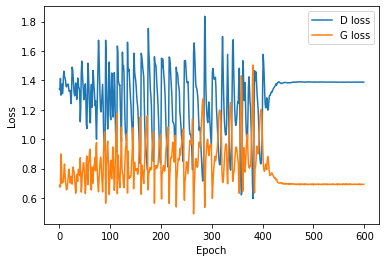

In [ ]:
# plot the losses
plt.plot(D_loss_hist, label="D loss")
plt.plot(G_loss_hist, label="G loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

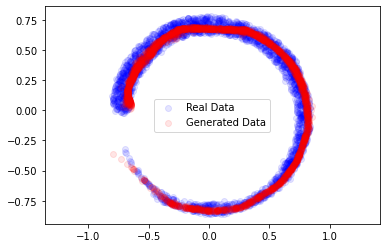

In [ ]:
# Let's see what the generator produces after training
with torch.no_grad():
    z = torch.randn(N, Z_DIM)
    x_fake = G(z)
plt.scatter(x[:, 0], x[:, 1], c="b", alpha=0.1, label="Real Data")
plt.scatter(x_fake[:, 0], x_fake[:, 1], c="r", alpha=0.1, label="Generated Data")
plt.axis("equal")
plt.legend()

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


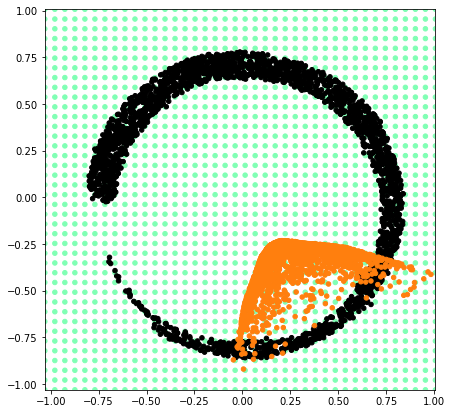

In [ ]:
# render
anim = save_animation(timesteps, d_fields, lims=lims)

In [ ]:
# let's visualize the training process
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(5, 1))
plt.xlabel("Discriminator Output")
plt.xticks([0, 50, 100, 150, 200, 250], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
plt.yticks([])
plt.imshow(gradient, aspect="auto", cmap=plt.get_cmap("rainbow"))
# convert to html5 video
# this might take a time
HTML(anim.to_html5_video())

# orange points are the generated data
# blue points are the real data

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
anim.save("inzva.mp4")

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


### What's next?
* Try the training with different sampling distributions (i.e. a uniform dist. instead of $N(0, 1).
* Try with different embedding dimensions (e.g. `Z_DIM=1`).
* Try with different datasets.